In [155]:
import os
print(os.getcwd())

import sys
sys.path.append('/home/saraiva/Documentos/GitHub/data-science-analytics/utils')
from my_tools import custom_inspect_class
from my_tools import unpack_list

from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import tqdm
import time
import random
import matplotlib.pyplot as plt

#Regression Algorithms
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as XGBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Classifier Algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#Clustering Algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering

#Regression Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

#Classification Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import auc

#Clustering Metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

from sklearn.datasets import load_boston
from pprint import pprint


X,y = load_boston(True)
data_columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df = pd.DataFrame(pd.concat([pd.DataFrame(X),pd.Series(y)],axis=1).values,
                            columns = data_columns)


/home/saraiva/Documentos/GitHub/data-science-analytics/notebooks


In [52]:
method_dict_regression ={
         
           'algo': 
                   {
                    AdaBoostRegressor.__name__ : AdaBoostRegressor,
                    BaggingRegressor.__name__ : BaggingRegressor,
                    GradientBoostingRegressor.__name__ : GradientBoostingRegressor,
                    RandomForestRegressor.__name__ : RandomForestRegressor ,
                    XGBoostRegressor.__name__ : XGBoostRegressor,
                   },                           
          
          'eval_metric' : 
                                 [mean_absolute_error,
                                  mean_squared_error,                                  
                                  mean_squared_log_error,],
                        
          'space' : 
                      {
                       AdaBoostRegressor.__name__ : {},
                       BaggingRegressor.__name__ : {},
                       GradientBoostingRegressor.__name__ : {}, 
                       RandomForestRegressor.__name__ :
                                                    { 
                                                      'bootstrap' :[True,False], 
                                                      'max_depth' : list(range(2, 10)),
                                                      'max_features' : ['auto','sqrt','log2'],
                                                      'min_samples_leaf': list(range(5,20)), 
                                                      'n_estimators': list(range(30, 300 ,5))
                                                    },
                       
                      XGBoostRegressor.__name__ : {},                                            
                      }           
                    
        }

In [255]:
class AutomatedRegression():
    
    def __init__(self,method_dict):
        self.method_dict = method_dict
        self.metric_list = method_dict['eval_metric']
        
    def pretty_print(self):
        '''Method to pprint some information
        First - Information about the method_dict whict dictionary possess'''
        pprint(self.method_dict)
        
    def fit_predict_tune(self,X,y,
                         choosen_algo,
                         number_splits = 5,
                         iterations = 20):
        
        self.choosen_algo = choosen_algo
        param_grid = self.method_dict['space'][choosen_algo]
        
        param_col = [key for key in param_grid.keys()] + [metrics.__name__ for metrics in self.metric_list]
        
        lots_vals = list()
        print(choosen_algo)
        for rounds in tqdm.tqdm_notebook(range(iterations)):
            #Aleatoriza os parametros
            params = { key : random.sample(value,1)[0] for key,value in param_grid.items()}

            kf = KFold(n_splits = number_splits,shuffle = True)
            matrix_metrics = []
            counter = 1
            
            for train_idx,test_idx in kf.split(X):

                X_train,X_test = X.loc[train_idx,:],X.loc[test_idx,:]
                y_train,y_test = y.loc[train_idx,:],y.loc[test_idx,:]

                new_algo = method_dict_regression['algo'][choosen_algo](**params)

                new_algo.fit(X_train,np.ravel(y_train))
                y_pred = new_algo.predict(X_test)
                
                evaluation_list = []
                for evaluations in self.metric_list:
                    result = evaluations(y_test,y_pred)
                    evaluation_list.append(result)
                matrix_metrics.append(evaluation_list)
                
            #Dataframe criado com os resultados das metricas em cada fold
            fold_dataframe = pd.DataFrame(matrix_metrics,
                                          columns = [metrics.__name__ for metrics in self.metric_list])

            # Return list of results
            metrics_results = fold_dataframe.mean().tolist()
            vals = list(params.values()) + metrics_results
            lots_vals.append(vals)
            
            self.result_dataframe = pd.DataFrame(lots_vals,columns = param_col)
            self.result_dataframe['choosen_algo'] = choosen_algo
        
        #if(report == True):
        
        return self.result_dataframe
    
    def reports(self,main_metric):
        
        display(self.result_dataframe.sort_values(by = main_metric).head(5))
        self.desc_results = self.result_dataframe.describe()
        display(self.result_dataframe.describe())
        
        print("The mean of the main metric is : {}".format(self.desc_results.loc['mean'][main_metric]))
        print("The median of the main metric is : {}".format(self.desc_results.loc['50%'][main_metric]))
        print("The standard deviation of the main metric is : {}".format(self.desc_results.loc['std'][main_metric]))
        print('Mean + 3*sigma : {}'.
              format(self.desc_results.loc['mean'][main_metric] + 3*self.desc_results.loc['std'][main_metric]))
        print('Mean - 3*sigma : {}'.
              format(self.desc_results.loc['mean'][main_metric] - 3*self.desc_results.loc['std'][main_metric]))
        print("The amplitude of the main metric is : {}".
              format(self.desc_results.loc['max'][main_metric] - self.desc_results.loc['min'][main_metric]))

        plt.figure(figsize=(10,7))
        
        kwargs = dict(histtype='stepfilled', alpha=0.8, ec="k")

        plt.hist(self.result_dataframe[str(main_metric)],
                 align='mid',
                 density = True,
                 stacked = True,
                 **kwargs)
        
        plt.xlabel(main_metric)
        plt.ylabel('Probability')
        plt.title('Histogram of IQ - {}'.format(self.choosen_algo))
        #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
        plt.grid(True)
        plt.show()
    
    def info_full_reports(self, X, y, iter_report, number_splits):
        
        self.X_EXOGENOUS = X
        self.Y_ENDOGENOUS = y
        self.ITER_REPORT = iter_report
        self.NUM_SPLITS = number_splits
        
    def auto_full_reports(self,main_metric):
        
        for alg in method_dict_regression['algo'].keys():
            temp_ar = AutomatedRegression(method_dict=method_dict_regression)
            
            temp_ar.fit_predict_tune(X = pd.DataFrame(self.X_EXOGENOUS),
                                     y = pd.DataFrame(self.Y_ENDOGENOUS),
                                     choosen_algo = alg,
                                     number_splits = self.NUM_SPLITS,
                                     iterations = self.ITER_REPORT)
            temp_ar.reports(main_metric)
    

AdaBoostRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
4,2.731978,12.998898,0.032166,AdaBoostRegressor
2,2.816416,14.015747,0.033003,AdaBoostRegressor
1,2.756071,15.448951,0.033073,AdaBoostRegressor
0,2.794778,15.492124,0.032592,AdaBoostRegressor
3,2.838169,15.718784,0.034062,AdaBoostRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,5.000000,5.000000,5.000000
mean,2.787482,14.734900,0.032979
std,0.043379,1.181331,0.000706
min,2.731978,12.998898,0.032166
25%,2.756071,14.015747,0.032592
50%,2.794778,15.448951,0.033003
75%,2.816416,15.492124,0.033073
max,2.838169,15.718784,0.034062


The mean of the main metric is : 14.734900442968378
The median of the main metric is : 15.448950509359012
The standard deviation of the main metric is : 1.1813307493764043
Mean + 3*sigma : 18.27889269109759
Mean - 3*sigma : 11.190908194839166
The amplitude of the main metric is : 2.7198860069677746


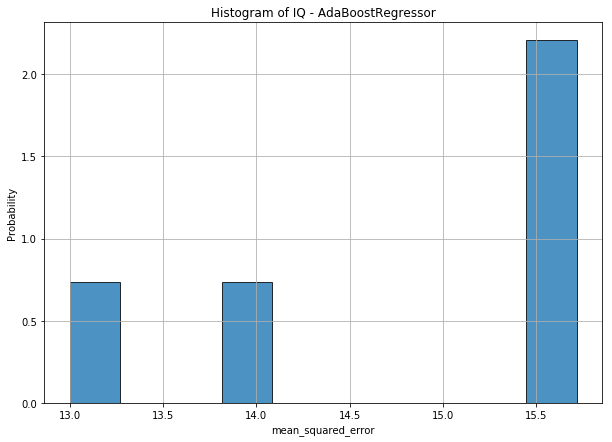

BaggingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
4,2.281592,10.899059,0.022458,BaggingRegressor
1,2.281173,11.001506,0.021780,BaggingRegressor
0,2.356782,11.525366,0.023411,BaggingRegressor
3,2.305997,11.660931,0.025967,BaggingRegressor
2,2.528796,14.836455,0.027562,BaggingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,5.000000,5.000000,5.000000
mean,2.350868,11.984664,0.024236
std,0.104119,1.627391,0.002446
min,2.281173,10.899059,0.021780
25%,2.281592,11.001506,0.022458
50%,2.305997,11.525366,0.023411
75%,2.356782,11.660931,0.025967
max,2.528796,14.836455,0.027562


The mean of the main metric is : 11.984663576004658
The median of the main metric is : 11.525365847408267
The standard deviation of the main metric is : 1.6273912171188702
Mean + 3*sigma : 16.86683722736127
Mean - 3*sigma : 7.102489924648047
The amplitude of the main metric is : 3.937396029897103


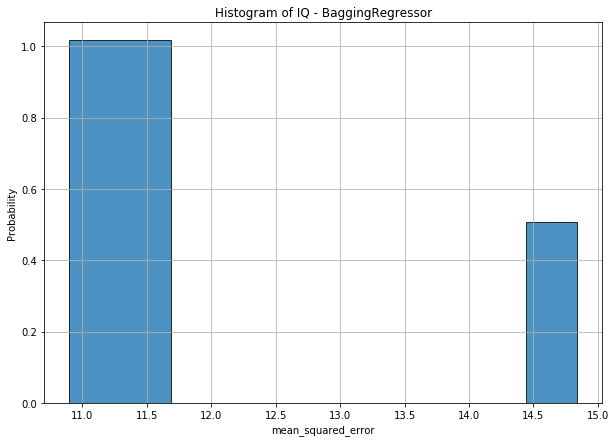

GradientBoostingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
4,2.127388,9.289735,0.020118,GradientBoostingRegressor
3,2.168189,9.701727,0.020405,GradientBoostingRegressor
1,2.193364,9.871170,0.021738,GradientBoostingRegressor
2,2.229680,10.403430,0.022927,GradientBoostingRegressor
0,2.194846,10.681089,0.020993,GradientBoostingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,5.000000,5.000000,5.000000
mean,2.182693,9.989430,0.021236
std,0.037876,0.555905,0.001130
min,2.127388,9.289735,0.020118
25%,2.168189,9.701727,0.020405
50%,2.193364,9.871170,0.020993
75%,2.194846,10.403430,0.021738
max,2.229680,10.681089,0.022927


The mean of the main metric is : 9.989429984550043
The median of the main metric is : 9.871169900898456
The standard deviation of the main metric is : 0.5559046949417284
Mean + 3*sigma : 11.657144069375228
Mean - 3*sigma : 8.321715899724857
The amplitude of the main metric is : 1.3913541126714613


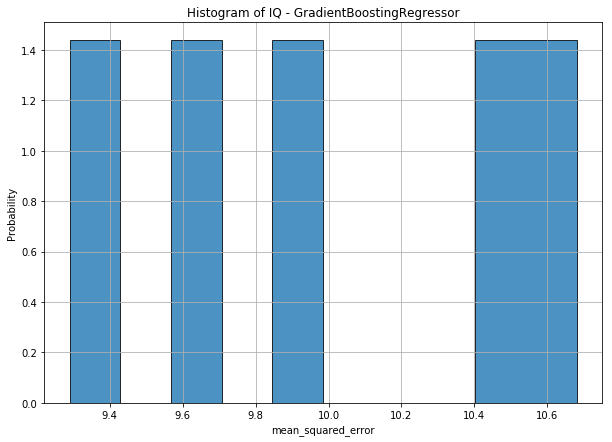

RandomForestRegressor


,bootstrap,max_depth,max_features,min_samples_leaf,n_estimators,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
1,False,8,log2,9,190,2.542725,15.197183,0.026666,RandomForestRegressor
0,True,5,log2,8,115,2.724052,17.525831,0.030856,RandomForestRegressor
4,False,8,log2,18,45,2.854736,19.647976,0.033374,RandomForestRegressor
2,True,5,sqrt,10,225,2.894551,20.070351,0.034296,RandomForestRegressor
3,True,6,sqrt,14,190,2.983341,21.910385,0.036319,RandomForestRegressor


,max_depth,min_samples_leaf,n_estimators,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000
mean,6.400000,11.800000,153.00000,2.799881,18.870345,0.032302
std,1.516575,4.147288,72.50862,0.171397,2.578100,0.003712
min,5.000000,8.000000,45.00000,2.542725,15.197183,0.026666
25%,5.000000,9.000000,115.00000,2.724052,17.525831,0.030856
50%,6.000000,10.000000,190.00000,2.854736,19.647976,0.033374
75%,8.000000,14.000000,190.00000,2.894551,20.070351,0.034296
max,8.000000,18.000000,225.00000,2.983341,21.910385,0.036319


The mean of the main metric is : 18.870345162376925
The median of the main metric is : 19.647976456504328
The standard deviation of the main metric is : 2.578100350599583
Mean + 3*sigma : 26.604646214175673
Mean - 3*sigma : 11.136044110578176
The amplitude of the main metric is : 6.7132019432556795


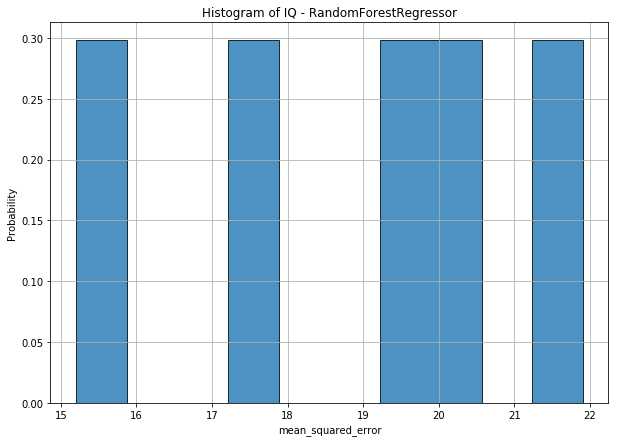

XGBRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
1,2.061416,8.453004,0.018512,XGBRegressor
2,2.199758,9.837622,0.020529,XGBRegressor
3,2.153150,9.945589,0.020098,XGBRegressor
4,2.202738,10.439132,0.021127,XGBRegressor
0,2.338705,11.368701,0.025246,XGBRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,5.000000,5.000000,5.000000
mean,2.191154,10.008810,0.021102
std,0.100319,1.059282,0.002511
min,2.061416,8.453004,0.018512
25%,2.153150,9.837622,0.020098
50%,2.199758,9.945589,0.020529
75%,2.202738,10.439132,0.021127
max,2.338705,11.368701,0.025246


The mean of the main metric is : 10.00880961447014
The median of the main metric is : 9.945588858715023
The standard deviation of the main metric is : 1.0592823744839064
Mean + 3*sigma : 13.186656737921858
Mean - 3*sigma : 6.830962491018421
The amplitude of the main metric is : 2.9156973840690252


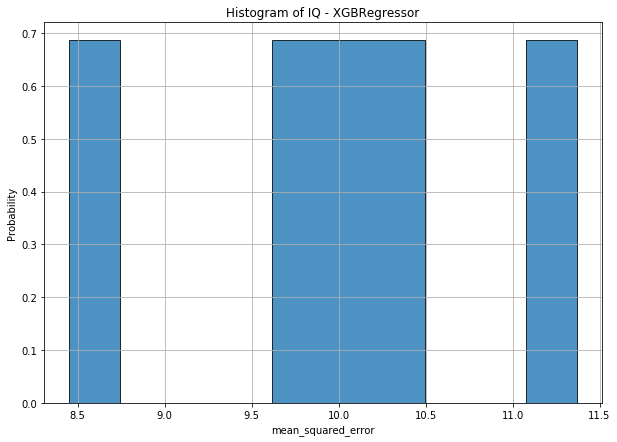

In [256]:
it_lives = AutomatedRegression(method_dict_regression)
it_lives.info_full_reports(X,y,5,5)
it_lives.auto_full_reports('mean_squared_error')

AdaBoostRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
220,2.681472,12.205376,0.030939,AdaBoostRegressor
25,2.725119,12.359046,0.031496,AdaBoostRegressor
45,2.685899,12.488953,0.030388,AdaBoostRegressor
176,2.753564,12.517479,0.031648,AdaBoostRegressor
221,2.661310,12.572413,0.030034,AdaBoostRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000
mean,2.785780,14.763234,0.032544
std,0.066621,1.388864,0.001578
min,2.626689,12.205376,0.029019
25%,2.740698,13.839551,0.031449
50%,2.780541,14.517671,0.032374
75%,2.826705,15.601481,0.033451
max,3.116421,20.336176,0.041501


The mean of the main metric is : 14.76323422254443
The median of the main metric is : 14.51767100700594
The standard deviation of the main metric is : 1.3888644201916809
Mean + 3*sigma : 18.929827483119475
Mean - 3*sigma : 10.596640961969387
The amplitude of the main metric is : 8.130800034205599


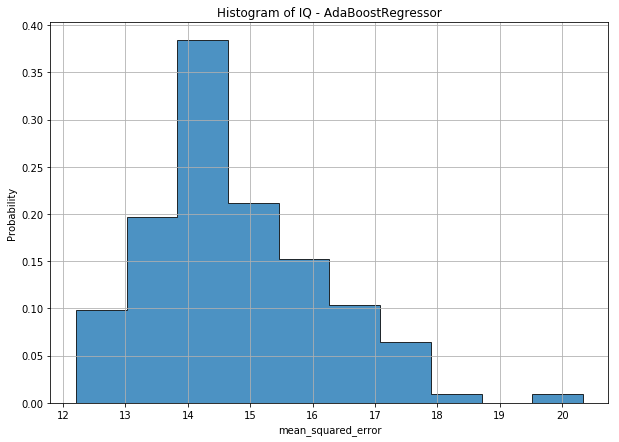

BaggingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
217,2.263508,9.972265,0.021393,BaggingRegressor
144,2.205409,10.060959,0.021471,BaggingRegressor
120,2.216066,10.142930,0.020752,BaggingRegressor
91,2.239730,10.194225,0.022260,BaggingRegressor
248,2.242647,10.335696,0.020935,BaggingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000
mean,2.363422,12.515514,0.024263
std,0.066378,1.281078,0.001774
min,2.185031,9.972265,0.020177
25%,2.317184,11.583889,0.022958
50%,2.365452,12.289411,0.024117
75%,2.407539,13.286424,0.025521
max,2.575434,17.550585,0.030359


The mean of the main metric is : 12.515513662799444
The median of the main metric is : 12.289411386138614
The standard deviation of the main metric is : 1.2810782381576795
Mean + 3*sigma : 16.358748377272484
Mean - 3*sigma : 8.672278948326404
The amplitude of the main metric is : 7.578320566880219


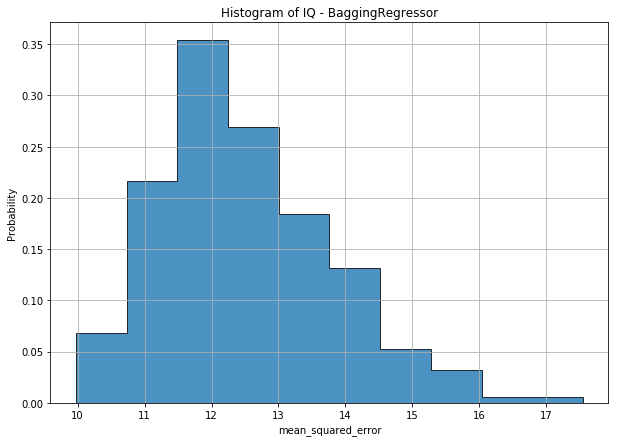

GradientBoostingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
156,2.004505,7.629083,0.017737,GradientBoostingRegressor
176,2.020908,8.028944,0.017388,GradientBoostingRegressor
52,2.015412,8.088932,0.017145,GradientBoostingRegressor
193,2.006397,8.194189,0.018846,GradientBoostingRegressor
98,2.059983,8.196652,0.018499,GradientBoostingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000
mean,2.134165,9.521738,0.019832
std,0.052848,0.897192,0.001094
min,2.004505,7.629083,0.017145
25%,2.096533,8.902755,0.019089
50%,2.132093,9.286932,0.019772
75%,2.165063,9.937362,0.020551
max,2.301061,12.747712,0.023077


The mean of the main metric is : 9.52173773490403
The median of the main metric is : 9.28693150808748
The standard deviation of the main metric is : 0.8971923067096721
Mean + 3*sigma : 12.213314655033047
Mean - 3*sigma : 6.830160814775015
The amplitude of the main metric is : 5.118628871720439


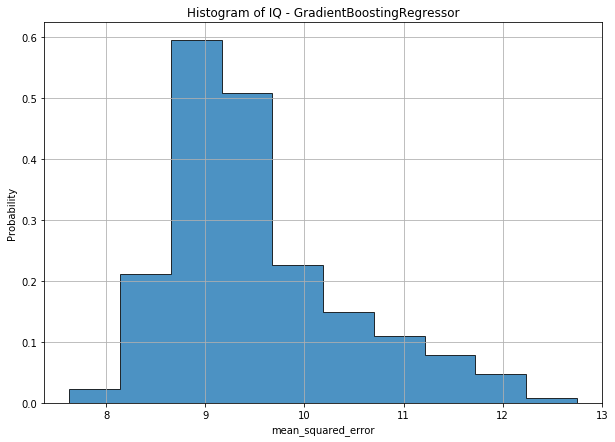

RandomForestRegressor


,bootstrap,max_depth,max_features,min_samples_leaf,n_estimators,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
105,False,9,log2,6,125,2.370464,13.338774,0.024231,RandomForestRegressor
205,False,8,sqrt,5,210,2.393522,13.597210,0.022870,RandomForestRegressor
94,False,7,log2,6,280,2.454003,13.713502,0.025034,RandomForestRegressor
122,False,6,log2,7,250,2.538768,14.299003,0.025655,RandomForestRegressor
244,False,7,log2,7,120,2.484681,14.400610,0.026105,RandomForestRegressor


,max_depth,min_samples_leaf,n_estimators,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,5.492000,11.736000,162.980000,2.976391,20.597036,0.037116
std,2.306342,4.309593,78.712147,0.371399,4.502319,0.009151
min,2.000000,5.000000,30.000000,2.370464,13.338774,0.022870
25%,3.000000,8.000000,100.000000,2.683050,17.350442,0.030577
50%,6.000000,11.000000,167.500000,2.896597,19.624802,0.034467
75%,7.750000,16.000000,228.750000,3.176879,22.886268,0.041202
max,9.000000,19.000000,295.000000,4.013373,32.942068,0.065335


The mean of the main metric is : 20.597035571475843
The median of the main metric is : 19.62480232539911
The standard deviation of the main metric is : 4.5023187538698295
Mean + 3*sigma : 34.10399183308533
Mean - 3*sigma : 7.090079309866354
The amplitude of the main metric is : 19.603294147529688


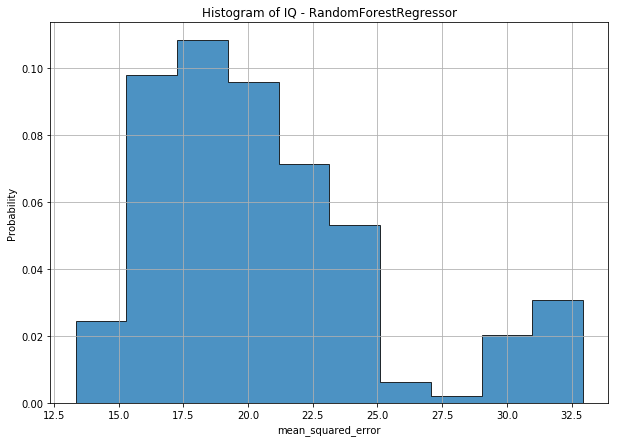

XGBRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
70,2.073678,8.429050,0.018515,XGBRegressor
121,2.059808,8.523998,0.018475,XGBRegressor
84,2.123508,8.719456,0.019265,XGBRegressor
17,2.107510,8.728770,0.017234,XGBRegressor
95,2.077524,8.765366,0.018956,XGBRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000
mean,2.194039,10.253896,0.020849
std,0.051288,0.902152,0.001177
min,2.059808,8.429050,0.017234
25%,2.159473,9.582930,0.019960
50%,2.188419,10.123570,0.020791
75%,2.224808,10.814681,0.021734
max,2.325367,13.852173,0.024924


The mean of the main metric is : 10.253895561379542
The median of the main metric is : 10.123570011095488
The standard deviation of the main metric is : 0.9021522349115128
Mean + 3*sigma : 12.96035226611408
Mean - 3*sigma : 7.5474388566450035
The amplitude of the main metric is : 5.423123155331114


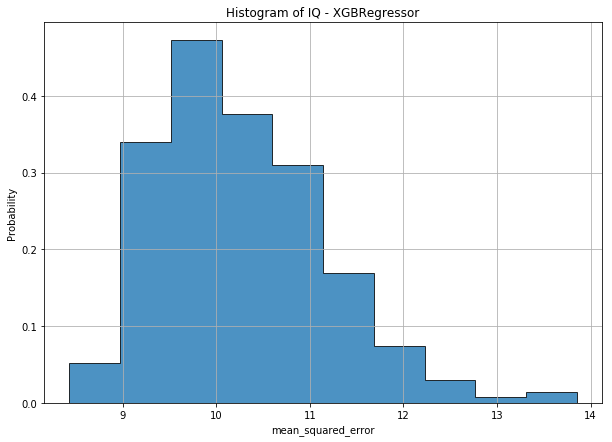

In [237]:
w = AutomatedRegression(method_dict_regression)
w.auto_full_reports('mean_squared_error')

AdaBoostRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
68,2.689208,12.272581,0.030126,AdaBoostRegressor
221,2.692811,12.491926,0.031041,AdaBoostRegressor
211,2.659398,12.515090,0.030849,AdaBoostRegressor
1,2.681022,12.538019,0.030133,AdaBoostRegressor
243,2.693983,12.622044,0.031282,AdaBoostRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000
mean,2.784422,14.703568,0.032548
std,0.063776,1.293978,0.001479
min,2.633475,12.272581,0.029511
25%,2.736490,13.777065,0.031479
50%,2.781526,14.368900,0.032306
75%,2.829023,15.562878,0.033527
max,3.016918,19.356772,0.038176


The mean of the main metric is : 14.703567883143894
The median of the main metric is : 14.36889993559814
The standard deviation of the main metric is : 1.293977559932054
Mean + 3*sigma : 18.585500562940055
Mean - 3*sigma : 10.821635203347732
The amplitude of the main metric is : 7.084191484341321


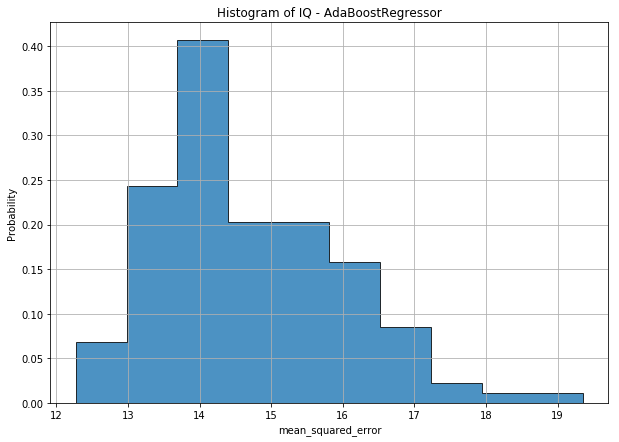

BaggingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
167,2.171630,9.434650,0.020801,BaggingRegressor
231,2.222265,9.861817,0.022406,BaggingRegressor
129,2.227690,10.342064,0.019682,BaggingRegressor
115,2.261103,10.360561,0.022374,BaggingRegressor
5,2.286238,10.371373,0.021951,BaggingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000
mean,2.363756,12.537925,0.024283
std,0.066592,1.269053,0.001668
min,2.171630,9.434650,0.019682
25%,2.316325,11.615952,0.023117
50%,2.360453,12.338880,0.024160
75%,2.411838,13.199581,0.025243
max,2.541786,16.823385,0.029151


The mean of the main metric is : 12.537924971663747
The median of the main metric is : 12.338880227140361
The standard deviation of the main metric is : 1.2690533748070625
Mean + 3*sigma : 16.345085096084937
Mean - 3*sigma : 8.73076484724256
The amplitude of the main metric is : 7.388734746651137


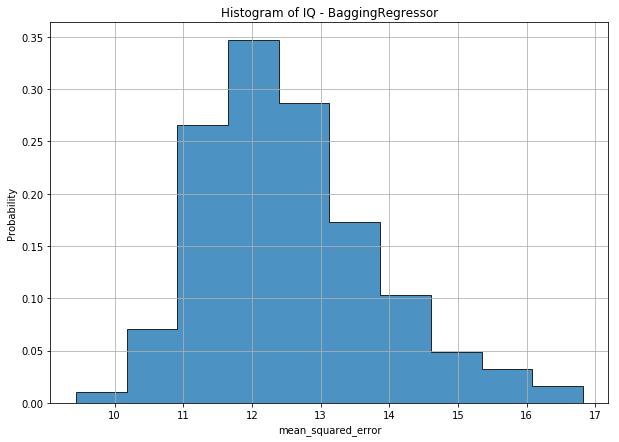

GradientBoostingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
74,2.066883,8.155480,0.019169,GradientBoostingRegressor
224,2.039906,8.162081,0.020158,GradientBoostingRegressor
5,2.089283,8.223349,0.018172,GradientBoostingRegressor
222,2.035069,8.307408,0.019184,GradientBoostingRegressor
245,2.040496,8.323450,0.018272,GradientBoostingRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000
mean,2.139078,9.627086,0.020057
std,0.053912,0.955778,0.001193
min,2.030279,8.155480,0.017494
25%,2.094476,8.929735,0.019179
50%,2.135288,9.336608,0.020006
75%,2.173302,10.089141,0.020752
max,2.303715,12.860034,0.023663


The mean of the main metric is : 9.627085876700026
The median of the main metric is : 9.336607588947949
The standard deviation of the main metric is : 0.95577761710004
Mean + 3*sigma : 12.494418728000145
Mean - 3*sigma : 6.759753025399906
The amplitude of the main metric is : 4.704554451234124


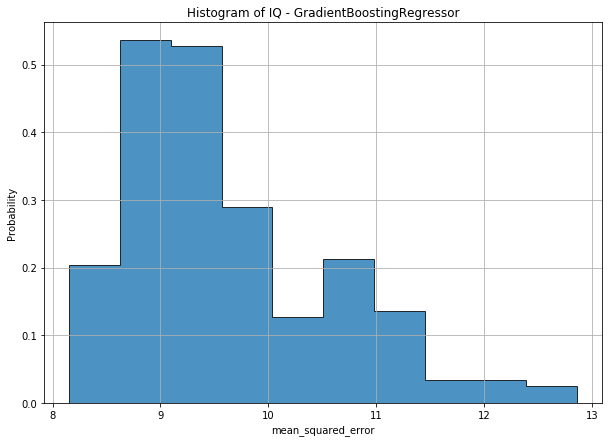

RandomForestRegressor


,bootstrap,max_depth,max_features,min_samples_leaf,n_estimators,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
227,False,9,sqrt,5,275,2.325620,13.560623,0.023867,RandomForestRegressor
46,False,7,sqrt,5,285,2.460916,13.794304,0.024676,RandomForestRegressor
166,False,5,log2,5,295,2.546121,13.884451,0.026681,RandomForestRegressor
167,False,9,log2,8,160,2.425577,13.935261,0.024921,RandomForestRegressor
122,False,7,log2,7,175,2.491084,14.313008,0.025822,RandomForestRegressor


,max_depth,min_samples_leaf,n_estimators,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,5.572000,12.024000,158.820000,3.003119,21.064894,0.037705
std,2.346666,4.331567,72.457629,0.371689,4.539308,0.009076
min,2.000000,5.000000,30.000000,2.325620,13.560623,0.023867
25%,4.000000,8.000000,96.250000,2.733221,18.064257,0.031346
50%,6.000000,12.000000,155.000000,2.906837,20.122432,0.034963
75%,8.000000,16.000000,223.750000,3.175773,23.006939,0.041969
max,9.000000,19.000000,295.000000,4.019918,32.840727,0.067863


The mean of the main metric is : 21.06489391637452
The median of the main metric is : 20.122432360190324
The standard deviation of the main metric is : 4.539307890622556
Mean + 3*sigma : 34.68281758824219
Mean - 3*sigma : 7.446970244506851
The amplitude of the main metric is : 19.280103883307937


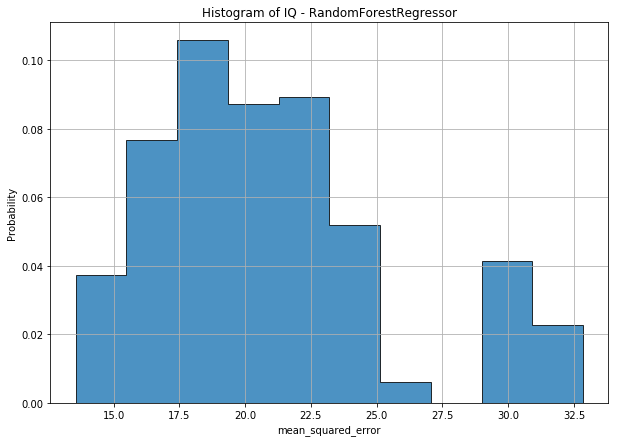

XGBRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error,choosen_algo
231,2.053876,8.185919,0.017719,XGBRegressor
219,2.052751,8.498874,0.018545,XGBRegressor
47,2.065484,8.523265,0.018508,XGBRegressor
233,2.090687,8.556539,0.018255,XGBRegressor
125,2.106249,8.624292,0.019661,XGBRegressor


,mean_absolute_error,mean_squared_error,mean_squared_log_error
count,250.000000,250.000000,250.000000
mean,2.186180,10.229715,0.020691
std,0.051832,1.041854,0.001223
min,2.052751,8.185919,0.017719
25%,2.155041,9.536496,0.019897
50%,2.182912,10.018847,0.020485
75%,2.220272,10.798663,0.021453
max,2.388461,15.822321,0.025973


The mean of the main metric is : 10.229715251555863
The median of the main metric is : 10.018846711828814
The standard deviation of the main metric is : 1.041854409307565
Mean + 3*sigma : 13.355278479478558
Mean - 3*sigma : 7.1041520236331674
The amplitude of the main metric is : 7.636401360797947


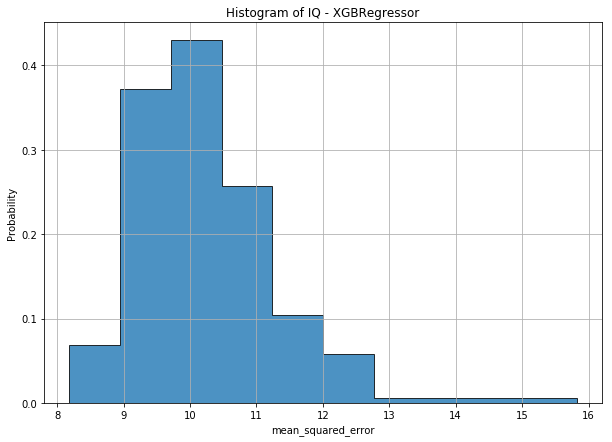

In [221]:
for alg in method_dict_regression['algo'].keys():
    temp_ar = AutomatedRegression(method_dict=method_dict_regression)
    temp_ar.fit_predict_tune(X = pd.DataFrame(X),y = pd.DataFrame(y),
                         choosen_algo = alg,iterations = 250)
    ar.reports(main_metric = 'mean_squared_error')